In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

In [4]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2021-01-11 14:19:23--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.184.144, 216.58.212.16, 172.217.169.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.184.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91,38K  --.-KB/s    in 0,07s   

2021-01-11 14:19:23 (1,28 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [15]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(50, return_sequences = True )))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(50,  return_sequences = False)))
model.add(Dense(total_words/4, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 10, 100)           321100    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 10, 100)           60400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 100)           0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 100)               60400     
_________________________________________________________________
dense_8 (Dense)              (None, 802)               81002     
_________________________________________________________________
dense_9 (Dense)              (None, 3211)              2578433   
Total params: 3,101,335
Trainable params: 3,101,335
Non-trainable params: 0
____________________________________________

In [16]:
 history = model.fit(predictors, label, epochs=20, verbose=1)

Epoch 1/20
484/484 [==============================] - 17s 27ms/step - loss: 7.4311 - accuracy: 0.0218
Epoch 2/20
484/484 [==============================] - 13s 28ms/step - loss: 6.4692 - accuracy: 0.0248
Epoch 3/20
484/484 [==============================] - 13s 27ms/step - loss: 6.4197 - accuracy: 0.0242
Epoch 4/20
484/484 [==============================] - 13s 26ms/step - loss: 6.3099 - accuracy: 0.0286
Epoch 5/20
484/484 [==============================] - 13s 27ms/step - loss: 6.1987 - accuracy: 0.0366
Epoch 6/20
484/484 [==============================] - 13s 27ms/step - loss: 6.1344 - accuracy: 0.0389
Epoch 7/20
484/484 [==============================] - 13s 27ms/step - loss: 6.0075 - accuracy: 0.0451
Epoch 8/20
484/484 [==============================] - 13s 27ms/step - loss: 5.9569 - accuracy: 0.0422
Epoch 9/20
484/484 [==============================] - 13s 27ms/step - loss: 5.8929 - accuracy: 0.0437
Epoch 10/20
484/484 [==============================] - 13s 27ms/step - loss: 5.797

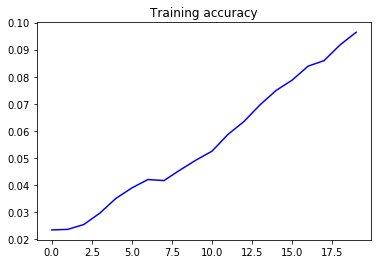

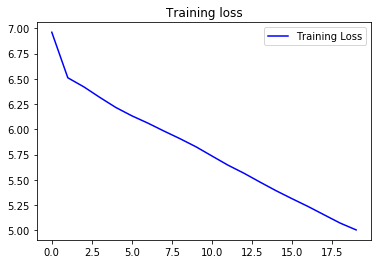

In [17]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [18]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Help me Obi Wan Kenobi, you're my only hope to thee be night ' lie on a heart to thee so know be be be survey know i my love in my love still ' still ' night eye in thee thee in thee lie to thee in my heart be know thee i am know i my love in my love still ' doth night ' light lie to my heart to thee thee so know be see youth still in my love and more and more delight night ' light lie to thee still be thee in my love be am is i am in thee thee
